# Linear t-SNE & UMAP Visualization (with PCA baseline)

We combine a **linear PCA** preprocessing with **t-SNE** and **UMAP** for 2D visualization.

## Math: PCA

Given centered data $X\in\mathbb{R}^{n\times d}$ and covariance $S=\frac{1}{n-1}X^{\top}X$, PCA solves $$S\mathbf{v}_{i}=\lambda_{i}\mathbf{v}_{i}$$ and uses top-$k$ eigenvectors to form $$Z = X V_k \in \mathbb{R}^{n\times k}.$$

## Math: t-SNE

High-D affinities (per point $i$): $$p_{j\mid i}=\frac{\exp(-\lVert\mathbf{x}_i-\mathbf{x}_j\rVert^2/2\sigma_i^2)}{\sum_{k\ne i} \exp(-\lVert\mathbf{x}_i-\mathbf{x}_k\rVert^2/2\sigma_i^2)}.$$ Perplexity: $$\text{Perp}(P_i)=2^{H(P_i)},\quad H(P_i)=-\sum_j p_{j\mid i}\log_2 p_{j\mid i}.$$ Symmetric: $$p_{ij}=\frac{p_{j\mid i}+p_{i\mid j}}{2n}.$$ Low-D affinities: $$q_{ij}\propto (1+\lVert\mathbf{y}_i-\mathbf{y}_j\rVert^2)^{-1}.$$ Objective: $$\mathrm{KL}(P\|Q)=\sum_{i\ne j}p_{ij}\log\frac{p_{ij}}{q_{ij}}.$$

## Math: UMAP (sketch)

High-D fuzzy graph weights: $$\mu_{ij}=\exp\!\left(-\frac{\max(0, d(\mathbf{x}_i,\mathbf{x}_j)-\rho_i)}{\sigma_i}\right).$$ Low-D similarity: $$q_{ij}=\frac{1}{1+a\lVert\mathbf{y}_i-\mathbf{y}_j\rVert^{2b}}.$$ Loss (cross-entropy): $$\mathcal{L}=\sum_{(i,j)}[-\mu_{ij}\log q_{ij}-(1-\mu_{ij})\log(1-q_{ij})].$$

### Bayes notation reminder

$$ P(y \mid \mathbf{x}) = \frac{P(\mathbf{x}\mid y)P(y)}{P(\mathbf{x})} \;\propto\; P(\mathbf{x}\mid y)P(y). $$ We start from **Bayes’ theorem** for $y\in\{1,\ldots,C\}$ and $\mathbf{x}=(x_1,\ldots,x_d)$

## Setup & Imports

In [1]:

# If UMAP is missing, you may install:
# !pip install umap-learn --quiet

import numpy as np
import matplotlib.pyplot as plt
from time import time

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

try:
    import umap
    HAS_UMAP = True
except Exception as e:
    print("UMAP not available. Install via: pip install umap-learn")
    HAS_UMAP = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams['figure.figsize'] = (6,5)
plt.rcParams['axes.grid'] = True


## Data (Iris & Digits) and PCA preprocessing

In [2]:

def load_iris():
    d = datasets.load_iris()
    return d.data, d.target, d.target_names

def load_digits():
    d = datasets.load_digits()
    X, y = d.data, d.target
    names = np.array([str(i) for i in np.unique(y)])
    return X, y, names

def pca_pre(X, n_pca=50):
    Xs = StandardScaler().fit_transform(X)
    k = min(n_pca, Xs.shape[1])
    Z = PCA(n_components=k, random_state=RANDOM_STATE).fit_transform(Xs)
    return Xs, Z

X_i, y_i, names_i = load_iris()
X_d, y_d, names_d = load_digits()

Xi_s, Zi = pca_pre(X_i, n_pca=4)
Xd_s, Zd = pca_pre(X_d, n_pca=50)

print("Iris:", X_i.shape, "Digits:", X_d.shape)


Iris: (150, 4) Digits: (1797, 64)


## Helper: Plot function

In [3]:

def plot_embed(Y, y, title, names=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Y[:,0], Y[:,1], c=y, s=16)
    ax.set_title(title)
    ax.set_xlabel("Dim 1"); ax.set_ylabel("Dim 2")
    if names is not None:
        uniq = np.unique(y)
        handles = [ax.scatter([], []) for _ in uniq]
        labels = [str(names[u]) if u < len(names) else str(u) for u in uniq]
        ax.legend(handles, labels, title="Classes", bbox_to_anchor=(1.04,1), loc="upper left")
    plt.tight_layout(); plt.show()


## Baseline: 2D PCA (Linear)

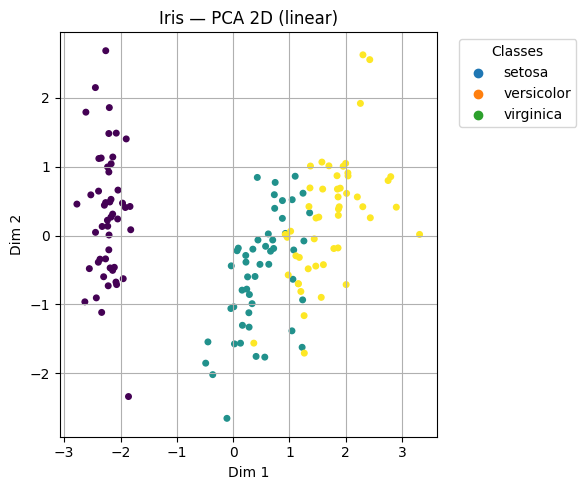

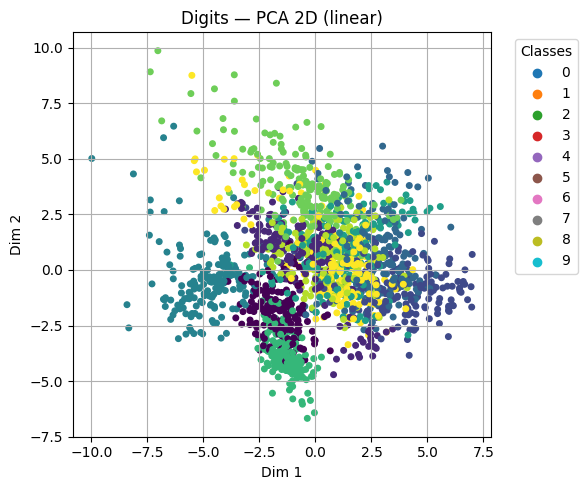

In [4]:

pca2_i = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(StandardScaler().fit_transform(X_i))
plot_embed(pca2_i, y_i, "Iris — PCA 2D (linear)", names_i)

pca2_d = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(StandardScaler().fit_transform(X_d))
plot_embed(pca2_d, y_d, "Digits — PCA 2D (linear)", names_d)


## t-SNE on PCA-reduced features

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


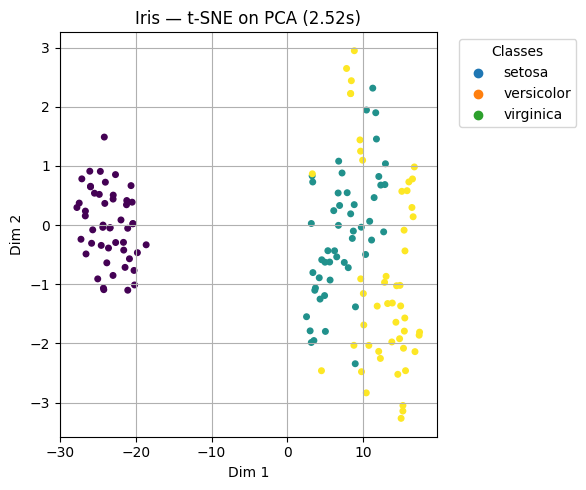

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


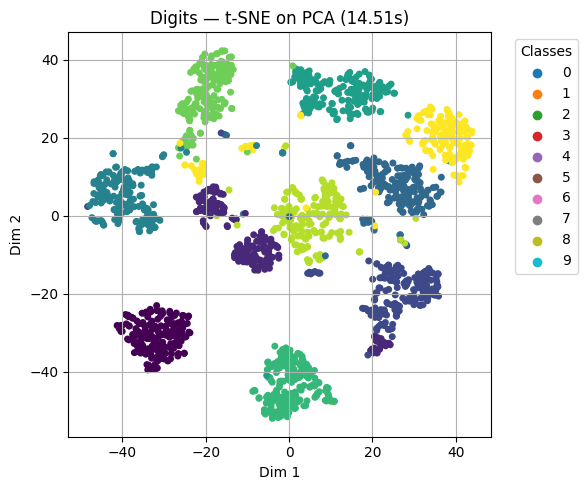

In [5]:

def run_tsne(Z, perplexity=30, n_iter=1000, init="pca", learning_rate="auto"):
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter,
                init=init, learning_rate=learning_rate, random_state=RANDOM_STATE)
    t0 = time(); Y = tsne.fit_transform(Z); t1 = time()
    return Y, t1 - t0

Yti, dti = run_tsne(Zi, perplexity=30, n_iter=1000)
plot_embed(Yti, y_i, f"Iris — t-SNE on PCA ({dti:.2f}s)", names_i)

Ytd, dtd = run_tsne(Zd, perplexity=30, n_iter=1000)
plot_embed(Ytd, y_d, f"Digits — t-SNE on PCA ({dtd:.2f}s)", names_d)


## UMAP on PCA-reduced features

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


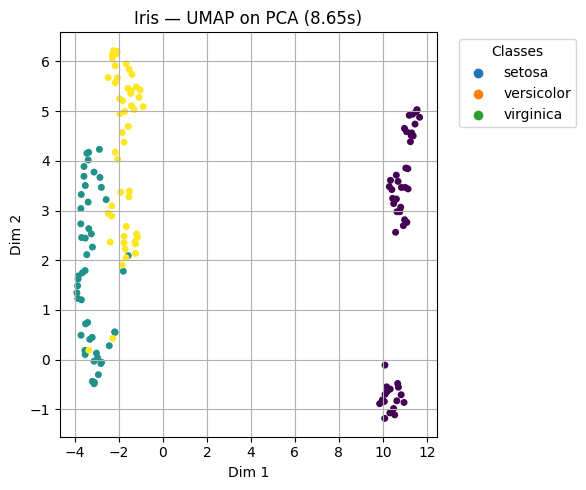

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


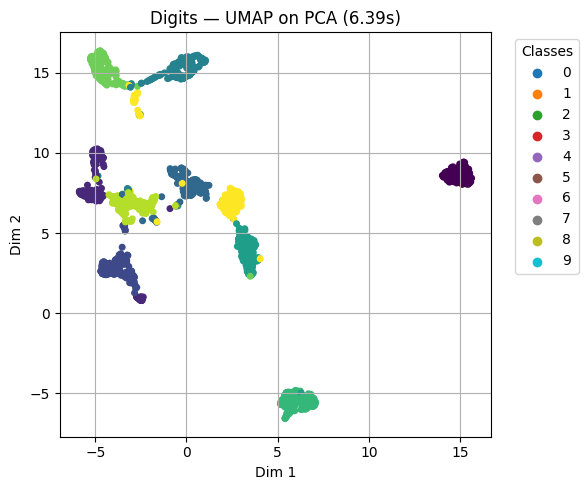

In [6]:

def run_umap(Z, n_neighbors=15, min_dist=0.1, metric="euclidean"):
    if not HAS_UMAP:
        raise ImportError("UMAP not installed. Run: pip install umap-learn")
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric,
                        random_state=RANDOM_STATE, n_components=2)
    t0 = time(); Y = reducer.fit_transform(Z); t1 = time()
    return Y, t1 - t0

if HAS_UMAP:
    Yui, dui = run_umap(Zi, n_neighbors=15, min_dist=0.1)
    plot_embed(Yui, y_i, f"Iris — UMAP on PCA ({dui:.2f}s)", names_i)

    Yud, dud = run_umap(Zd, n_neighbors=15, min_dist=0.1)
    plot_embed(Yud, y_d, f"Digits — UMAP on PCA ({dud:.2f}s)", names_d)
else:
    print("Skipping UMAP plots (umap-learn not installed).")
